In [1]:
import copy
import time
from tqdm.notebook import tqdm
from collections import namedtuple

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import glob
import SimpleITK as sitk
from PIL import Image
from imageio import imread
%matplotlib inline
from PIL import Image
from imageio import imread
from joblib import Parallel, delayed
from collections import namedtuple

In [3]:
df = pd.read_csv('/kaggle/input/dataset/dataset_ids_uniques.csv')


In [4]:
df

,seriesuid,coordX,coordY,coordZ,class,image_path
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1.790000,166.340000,-408.880000,1,/kaggle/input/luna16/subset2/subset2/1.3.6.1.4...
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.706024,54.602293,-150.737316,1,/kaggle/input/luna16/subset3/subset3/1.3.6.1.4...
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.890390,127.191988,-473.054548,1,/kaggle/input/luna16/subset1/subset1/1.3.6.1.4...
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.037827,33.931327,-170.970846,1,/kaggle/input/luna16/subset3/subset3/1.3.6.1.4...
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.831365,73.500317,1790.973040,1,/kaggle/input/luna16/subset1/subset1/1.3.6.1.4...
...,...,...,...,...,...,...
437,1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033...,118.234089,-15.913813,-200.733446,0,/kaggle/input/luna16/subset4/subset4/1.3.6.1.4...
438,1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558...,-111.277669,53.795319,-235.440611,0,/kaggle/input/luna16/subset2/subset2/1.3.6.1.4...
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075...,71.840000,-152.800000,-184.690000,0,/kaggle/input/luna16/subset3/subset3/1.3.6.1.4...
440,1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309...,-121.228532,-38.215873,-184.627016,0,/kaggle/input/luna16/subset1/subset1/1.3.6.1.4...


In [5]:
df = df.drop('image_path', axis=1)

In [6]:
df['energy_1'] = ''
df['correlation_1'] = ''
df['dissimilarity_1'] = ''
df['homogeneity_1'] = ''
df['contrast_1'] = ''

df['energy_2'] = ''
df['correlation_2'] = ''
df['dissimilarity_2'] = ''
df['homogeneity_2'] = ''
df['contrast_2'] = ''

df['energy_3'] = ''
df['correlation_3'] = ''
df['dissimilarity_3'] = ''
df['homogeneity_3'] = ''
df['contrast_3'] = ''

df['energy_4'] = ''
df['correlation_4'] = ''
df['dissimilarity_4'] = ''
df['homogeneity_4'] = ''
df['contrast_4'] = ''


In [7]:
df = df.reset_index(drop=True)

In [8]:
from skimage.feature import graycomatrix, graycoprops

In [9]:
df

,seriesuid,coordX,coordY,coordZ,class,energy_1,correlation_1,dissimilarity_1,homogeneity_1,contrast_1,...,energy_3,correlation_3,dissimilarity_3,homogeneity_3,contrast_3,energy_4,correlation_4,dissimilarity_4,homogeneity_4,contrast_4
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1.790000,166.340000,-408.880000,1,,,,,,...,,,,,,,,,,
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.706024,54.602293,-150.737316,1,,,,,,...,,,,,,,,,,
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.890390,127.191988,-473.054548,1,,,,,,...,,,,,,,,,,
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.037827,33.931327,-170.970846,1,,,,,,...,,,,,,,,,,
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.831365,73.500317,1790.973040,1,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033...,118.234089,-15.913813,-200.733446,0,,,,,,...,,,,,,,,,,
438,1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558...,-111.277669,53.795319,-235.440611,0,,,,,,...,,,,,,,,,,
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075...,71.840000,-152.800000,-184.690000,0,,,,,,...,,,,,,,,,,
440,1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309...,-121.228532,-38.215873,-184.627016,0,,,,,,...,,,,,,,,,,


In [10]:
j=0
for _, i in df.iterrows():
    print(j)
    file_path = glob.glob(f'/kaggle/input/luna16/subset*/*/{i.seriesuid}.mhd')
    mhd_file = sitk.ReadImage(file_path[0])
    ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
    ct_scan.clip(-1000, 1000, ct_scan)
    
    origin_xyz = mhd_file.GetOrigin()
    voxel_size_xyz = mhd_file.GetSpacing()
    direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
    origin_xyz_np = np.array(origin_xyz)
    voxel_size_xyz_np = np.array(voxel_size_xyz)

    center_xyz = (i.coordX,i.coordY,i.coordZ)
    cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np

# Since we'll be using column, row and index values to index into arrays,
# we round them to the nearest integer.
    cri = np.round(cri)

# Going forward, we'll need the scan to be in the order index, row, column
    irc = (int(cri[2]), int(cri[1]), int(cri[0]))
    
    dims_irc = (10, 25, 25)
    
    slice_list = []

    for axis, center_val in enumerate(irc):
    
    # Get start and end index for the dimension so that the
    # nodule center is at the center of the 3d array we extract
        start_index = int(round(center_val - dims_irc[axis]/2))
        end_index = int(start_index + dims_irc[axis])

    # Adjust the indexes if the start_index is out of the CT scan array
        if start_index < 0:
            start_index = 0
            end_index = int(dims_irc[axis])
    
        # Do the same check for the end_index
        if end_index > ct_scan.shape[axis]:
            end_index = ct_scan.shape[axis]
            start_index = int(ct_scan.shape[axis] - dims_irc[axis])
        
        slice_list.append(slice(start_index, end_index))
    
    tuple(slice_list)
    ct_scan_chunk = ct_scan[tuple(slice_list)]
    ct_scan_chunk.shape
    ctt = np.array(ct_scan_chunk).astype(int)
    max = np.max(ctt)
    min_val = np.min(ctt)
    max_val = np.max(ctt)

    # Normaliser le tableau à la plage [0, 255]
    nctt = (ctt - min_val) * (255 / (max_val - min_val))

    # Convertir le tableau en type entier
    nctt = nctt.astype(np.uint8)
    glcm_3d = np.zeros((256, 256, 1, 4))

    # Calculer la GLCM pour chaque plan de coupe (slice) de l'image 3D
    for z in range(nctt.shape[0]):
        glcm_slice = graycomatrix(nctt[z,:,:],[1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
        glcm_3d += glcm_slice
    
    glcm_sum = np.sum(glcm_3d)

    # Normaliser la matrice GLCM 3D
    glcm_3d_normalized = glcm_3d / glcm_sum
    
    GLCM_Energy = graycoprops(glcm_3d_normalized, 'energy')[0]
    df.at[j,'energy_1'] = GLCM_Energy[0]
    df.at[j,'energy_2']= GLCM_Energy[1]
    df.at[j,'energy_3']= GLCM_Energy[2]
    df.at[j,'energy_4']= GLCM_Energy[3]
    GLCM_corr = graycoprops(glcm_3d_normalized, 'correlation')[0]
    df.at[j,'correlation_1']=GLCM_corr[0]
    df.at[j,'correlation_2']= GLCM_corr[1]
    df.at[j,'correlation_3']= GLCM_corr[2]
    df.at[j,'correlation_4']= GLCM_corr[3]
    GLCM_diss = graycoprops(glcm_3d_normalized, 'dissimilarity')[0]
    df.at[j,'dissimilarity_1']=GLCM_diss[0]    
    df.at[j,'dissimilarity_2']=GLCM_diss[1]
    df.at[j,'dissimilarity_3']=GLCM_diss[2]
    df.at[j,'dissimilarity_4']=GLCM_diss[3]
    GLCM_hom = graycoprops(glcm_3d_normalized, 'homogeneity')[0]
    df.at[j,'homogeneity_1']= GLCM_hom[0]    
    df.at[j,'homogeneity_2']= GLCM_hom[1]
    df.at[j,'homogeneity_3']= GLCM_hom[2] 
    df.at[j,'homogeneity_4']= GLCM_hom[3]  
    GLCM_contr = graycoprops(glcm_3d_normalized, 'contrast')[0]
    df.at[j,'contrast_1']= GLCM_contr[0]
    df.at[j,'contrast_2']= GLCM_contr[1]
    df.at[j,'contrast_3']= GLCM_contr[2]
    df.at[j,'contrast_4']= GLCM_contr[3]
    j=j+1
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
df

,seriesuid,coordX,coordY,coordZ,class,energy_1,correlation_1,dissimilarity_1,homogeneity_1,contrast_1,...,energy_3,correlation_3,dissimilarity_3,homogeneity_3,contrast_3,energy_4,correlation_4,dissimilarity_4,homogeneity_4,contrast_4
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,1.790000,166.340000,-408.880000,1,0.034879,0.987856,7.513833,0.217818,167.094833,...,0.030351,0.974366,10.597667,0.168112,351.91,0.02953,0.971655,11.288021,0.152158,389.561285
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.706024,54.602293,-150.737316,1,0.029591,0.969231,7.941667,0.173149,155.187667,...,0.027563,0.945217,10.312333,0.150223,276.340667,0.02554,0.918889,12.394618,0.125281,408.722743
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.890390,127.191988,-473.054548,1,0.071062,0.95159,11.181667,0.207893,453.523667,...,0.066818,0.926606,14.7935,0.175191,687.926833,0.064606,0.868372,19.999479,0.149583,1269.474826
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.106164978370...,2.037827,33.931327,-170.970846,1,0.050466,0.970397,7.042833,0.25978,165.082167,...,0.048927,0.972839,7.205167,0.243362,151.460167,0.045574,0.983977,5.490104,0.239784,85.900174
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.831365,73.500317,1790.973040,1,0.019892,0.962675,12.8565,0.111406,319.315167,...,0.019391,0.949505,14.696167,0.103556,431.9385,0.017418,0.907197,20.453819,0.078521,803.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,1.3.6.1.4.1.14519.5.2.1.6279.6001.316393351033...,118.234089,-15.913813,-200.733446,0,0.019321,0.933001,20.033,0.067126,822.067,...,0.018779,0.950422,18.7215,0.064995,614.454833,0.018851,0.958447,17.330208,0.070716,509.086111
438,1.3.6.1.4.1.14519.5.2.1.6279.6001.191301539558...,-111.277669,53.795319,-235.440611,0,0.017318,0.569147,20.1255,0.053577,713.761167,...,0.017122,0.517508,21.761333,0.048467,805.776,0.017149,0.50033,21.694271,0.050228,837.068924
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.160216916075...,71.840000,-152.800000,-184.690000,0,0.030621,0.95223,15.1205,0.126324,538.989167,...,0.02952,0.923586,20.520333,0.101986,869.889,0.029025,0.920787,20.501215,0.097036,900.05434
440,1.3.6.1.4.1.14519.5.2.1.6279.6001.888291896309...,-121.228532,-38.215873,-184.627016,0,0.022515,0.839168,13.676667,0.076848,336.027667,...,0.02175,0.761832,16.465333,0.068333,508.431,0.021873,0.7644,16.282118,0.068494,504.051563


# **Train the model**

In [12]:
X = df
y = df['class']

In [13]:
X = X.drop(['class','seriesuid','coordX','coordY','coordZ'], axis=1)

In [14]:
X

,energy_1,correlation_1,dissimilarity_1,homogeneity_1,contrast_1,energy_2,correlation_2,dissimilarity_2,homogeneity_2,contrast_2,energy_3,correlation_3,dissimilarity_3,homogeneity_3,contrast_3,energy_4,correlation_4,dissimilarity_4,homogeneity_4,contrast_4
0,0.034879,0.987856,7.513833,0.217818,167.094833,0.029055,0.956268,13.678993,0.150372,600.963368,0.030351,0.974366,10.597667,0.168112,351.91,0.02953,0.971655,11.288021,0.152158,389.561285
1,0.029591,0.969231,7.941667,0.173149,155.187667,0.024426,0.918174,12.819271,0.113432,412.957813,0.027563,0.945217,10.312333,0.150223,276.340667,0.02554,0.918889,12.394618,0.125281,408.722743
2,0.071062,0.95159,11.181667,0.207893,453.523667,0.066779,0.909395,16.370486,0.16509,873.916667,0.066818,0.926606,14.7935,0.175191,687.926833,0.064606,0.868372,19.999479,0.149583,1269.474826
3,0.050466,0.970397,7.042833,0.25978,165.082167,0.042027,0.907608,12.258333,0.18946,499.89375,0.048927,0.972839,7.205167,0.243362,151.460167,0.045574,0.983977,5.490104,0.239784,85.900174
4,0.019892,0.962675,12.8565,0.111406,319.315167,0.017179,0.924812,18.463021,0.076863,650.928646,0.019391,0.949505,14.696167,0.103556,431.9385,0.017418,0.907197,20.453819,0.078521,803.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.019321,0.933001,20.033,0.067126,822.067,0.016374,0.873956,26.260764,0.055461,1544.921181,0.018779,0.950422,18.7215,0.064995,614.454833,0.018851,0.958447,17.330208,0.070716,509.086111
438,0.017318,0.569147,20.1255,0.053577,713.761167,0.017019,0.401807,22.795313,0.049585,1001.15191,0.017122,0.517508,21.761333,0.048467,805.776,0.017149,0.50033,21.694271,0.050228,837.068924
439,0.030621,0.95223,15.1205,0.126324,538.989167,0.025356,0.844255,28.549306,0.081419,1767.84375,0.02952,0.923586,20.520333,0.101986,869.889,0.029025,0.920787,20.501215,0.097036,900.05434
440,0.022515,0.839168,13.676667,0.076848,336.027667,0.021563,0.634887,19.593229,0.062791,780.803993,0.02175,0.761832,16.465333,0.068333,508.431,0.021873,0.7644,16.282118,0.068494,504.051563


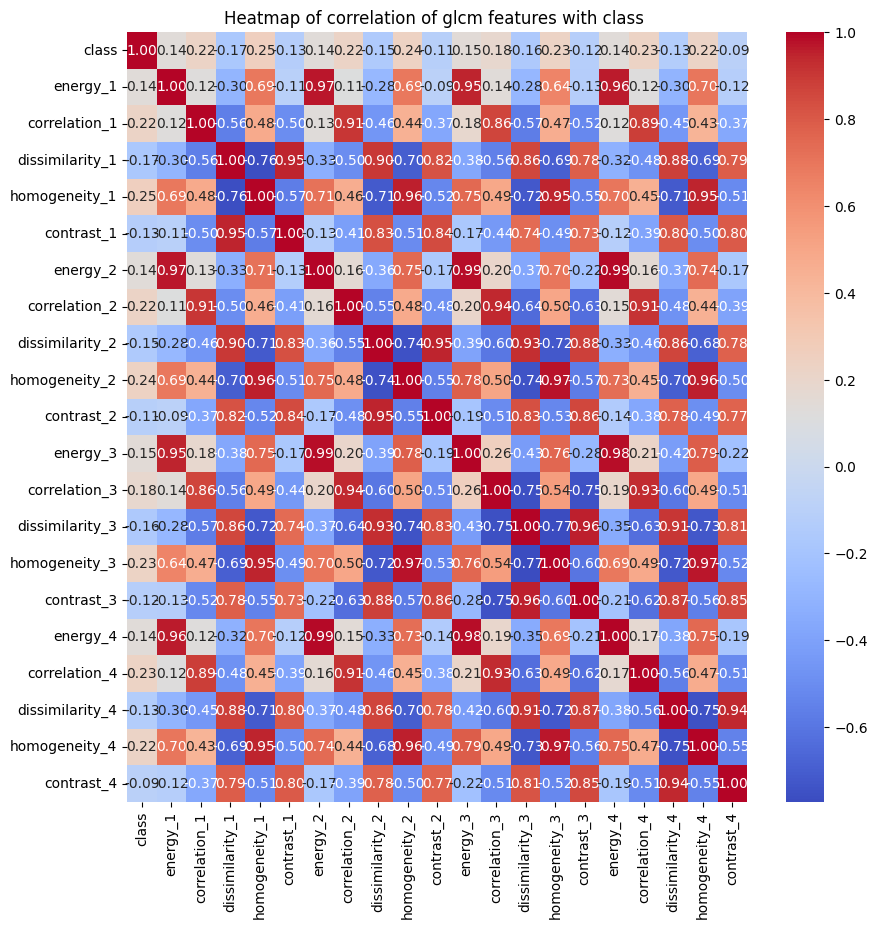

In [15]:
data= df
data= data.drop(['seriesuid','coordX','coordY','coordZ'], axis=1)


# Créez la heatmap
plt.figure(figsize=(10, 10) ) 
heatmap = sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of correlation of glcm features with class ")

# Affichez la heatmap
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train , X_test, Y_train , Y_test = train_test_split(X,y,test_size=0.2 ,random_state=1)

In [18]:
Y_train

438    0
232    1
80     1
46     1
381    0
      ..
255    1
72     1
396    0
235    1
37     1
Name: class, Length: 353, dtype: int64

In [19]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [20]:
best_C = None
best_gamma = None
best_score = -1
for C in np.arange( 1, 10):
#     for gamma in np.arange(0.001, 0.101, 0.001):
        model = SVC(kernel='rbf', C=C)
        model.fit(X_train, Y_train)
        score = model.score(X_test, Y_test)
        if score > best_score:
            Y_pred = model.predict(X_test)
            best_score = score
            best_C = C
#             best_gamma = gamma
print('Highest Accuracy Score: ', best_score)  
print(best_C)
# print(best_gamma)

Highest Accuracy Score:  0.6629213483146067
1


In [42]:
dump(model, 'GLCM_SVM.joblib')

['GLCM_SVM.joblib']

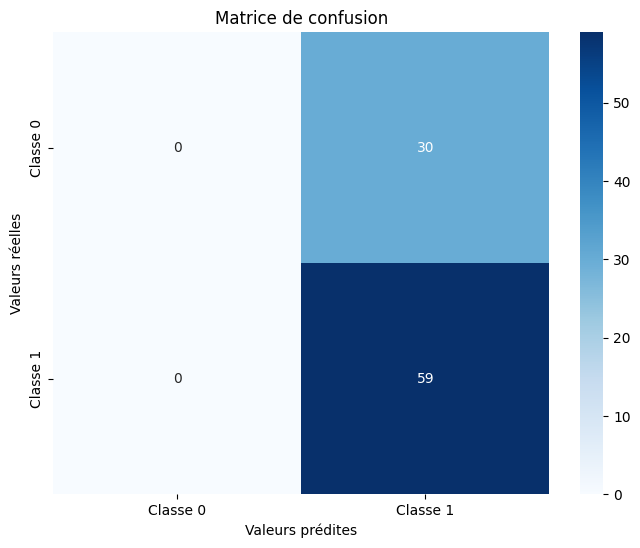

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=['Classe 0', 'Classe 1'], 
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calcul de la précision
precision = precision_score(Y_test, Y_pred)

# Calcul de la sensibilité (recall)
recall = recall_score(Y_test, Y_pred)

# Calcul du score F1
f1 = f1_score(Y_test, Y_pred)

print("Précision (Precision):", precision)
print("Sensibilité (Recall):", recall)
print("Score F1 (F1 score):", f1)

Précision (Precision): 0.6629213483146067
Sensibilité (Recall): 1.0
Score F1 (F1 score): 0.7972972972972973


In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

classifier = KNeighborsClassifier(n_neighbors=7,algorithm='brute')
classifier.fit(X_scaled, Y_train)
test_accuracy = classifier.score(scaler.transform(X_test), Y_test)
print(test_accuracy)

0.6853932584269663


In [40]:
# Assuming you have already trained your model and obtained predictions
predictions = classifier.predict(scaler.transform(X_test))

# Calculate precision, recall, and F1 score
precision = precision_score(Y_test, predictions)
recall = recall_score(Y_test, predictions)
f1 = f1_score(Y_test, predictions)

# Print the results
print("Précision (Precision):", precision)
print("Sensibilité (Recall):", recall)
print("Score F1 (F1 score):", f1)

Précision (Precision): 0.7183098591549296
Sensibilité (Recall): 0.864406779661017
Score F1 (F1 score): 0.7846153846153846


In [41]:
from joblib import dump
dump(classifier, 'GLCM_KNN.joblib')

['GLCM_KNN.joblib']